In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import UnivariateSpline,interp1d 
from os import listdir,path,walk
import matplotlib as mpl
from scipy.signal import savgol_filter
import lmfit as lm
import scipy.stats as stats
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import date

mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.linewidth'] = 1.5
pd.options.display.float_format = '{:,.4f}'.format

# Live-Cell Copy number

## Functions

In [4]:
#+++++++++++++++++++++++To calculate copy number and errors++++++++++++++++

def errn(intens_tar,intens_ref,n_ref,err_nref):    
    
    #+++++++++++++++++++++++
    #Picco, Andrea, et al. "Visualizing the functional architecture of the endocytic machinery." Elife 4 (2015): e04535.
    #See "Quantification of the number of molecules" in Methods
    #The target copy number n_tar is estimated as 
    #       n_tar    = i_tar/i_ref * n_ref   
    #The associated-error (err_ntar) is calculated as: 
    #       err_ntar = sqrt ( (n_tar/n_ref * err_nref)**2 + (n_tar/i_tar*err_itar)** + (n_tar/i_ref*err_iref)**2 )     
    #Where: 
    # i_tar   : Median Corrected Total Intensity (CTI) of the target protein 
    # i_ref   : Median CTI of the reference protein (Cse4 in our case)
    # n_ref   : Copy number of the reference protein ( = 76.8) [See Cieslinski, K, et al.,2023,https://doi.org/10.1083/jcb.202209094]
    # err_nref: Error associated to n_ref  ( = 9.8)[See Cieslinski, K, et al.,2023,https://doi.org/10.1083/jcb.202209094]
    # err_itar: Error associated to i_tar
    # err_iref: Error associated to i_ref
    #-----------------------
    # err_iref and err_itar are computed by following the next steps (here inten should be replaced by err_iref o err_tar)
    # l     = np.log(inten)    
    # err_l =  1.4826 * MAD(l) / np.sqrt(n)  ::: n = len(inten) -- The number of patches
    #-----------------------    
    #+++++++++++++++++++++++
    # Input  -> target_CTIs, reference_CTIs, reference_CN, reference_CN_error
    # Output -> target_CN , target_CN_SEM, i_tar_SEM, i_ref_SEM
    #+++++++++++++++++++++++ 
    
    i_tar  = np.median(intens_tar)
    i_ref  = np.median(intens_ref)

    l       = np.log(intens_tar)
    mad_l   = stats.median_abs_deviation(l)
    sigma_l = 1.4826*mad_l/np.sqrt(len(l))
    err_itar= i_tar*sigma_l
    
    l       = np.log(intens_ref)
    mad_l   = stats.median_abs_deviation(l)
    sigma_l = 1.4826*mad_l/np.sqrt(len(l))
    err_iref= i_ref*sigma_l    
    
    n_tar    = i_tar/i_ref*n_ref
    err_ntar = np.sqrt((n_tar/n_ref*err_nref)**2+(n_tar/i_tar*err_itar)**2+(n_tar/i_ref*err_iref)**2)
    
    return(n_tar,err_ntar,err_itar,err_iref)
##+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


def denplot(locs,xshift,ax=plt,style=1,**kwargs):    
    # Intensity-distribution is described by a log-normal kernel
    #+++++++++++++++Log-normal kernel++++++++++++++++++++++++++++            
    fit = stats.lognorm.fit(locs,floc=0)    
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++     
    xs  = np.arange(locs.min()-2,locs.max()+2)
    y   = stats.lognorm.pdf(xs,fit[0],loc=0,scale=fit[2])
    norm= np.max(y)/0.45
    y   = y/norm   
    
    ax.fill_betweenx(xs,xshift-y,xshift+y,**kwargs)       
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++            
    # Stripplot between the estimated kernel
    y   = stats.lognorm.pdf(locs,fit[0],loc=0,scale=fit[2])
    y   = y/norm
    xrand  = np.random.uniform(-y,y)
    if style == 1:
        ax.scatter(xshift+xrand,locs,color='w',edgecolors='k',linewidths=1,s=20,alpha=0.5)            
    else:
        ax.scatter(xshift+xrand,locs,facecolor='none',edgecolors='k',linewidths=1,s=20,alpha=0.8)                          
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++                               

## Fig1B & FigS2: Exocyst subunits copy number

 Subunit        Ntracks    Median +- SEM CTI
   exo70 target  20    376.0 +- 16.9
   exo70  refer  42   4768.7 +- 127.7
Copy number 6.1 +- 0.8
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
   exo84 target  17    396.5 +- 18.0
   exo84  refer  22   4769.7 +- 248.7
Copy number 6.4 +- 0.9
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    sec3 target  16    330.5 +- 30.0
    sec3  refer  34   4630.6 +- 259.2
Copy number 5.5 +- 0.9
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    sec5 target  18    440.5 +- 21.1
    sec5  refer  24   4677.9 +- 203.5
Copy number 7.2 +- 1.0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    sec6 target  21    394.2 +- 27.3
    sec6  refer  36   4339.1 +- 194.0
Copy number 7.0 +- 1.1
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    sec8 target  22    378.9 +- 15.4
    sec8  refer  38   4443.7 +- 199.1
Copy number 6.5 +- 0.9
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 

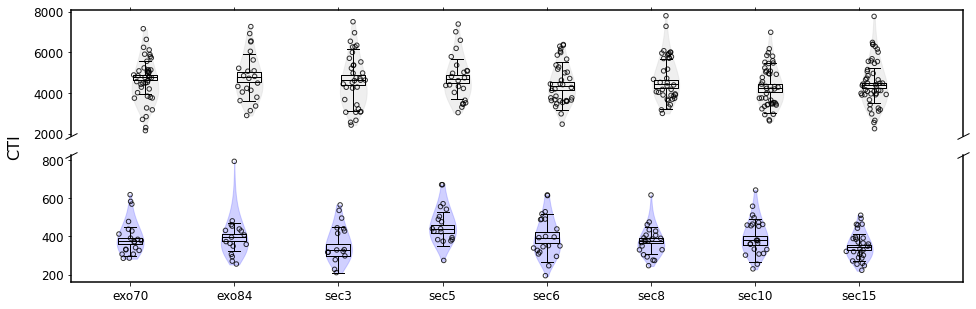

In [61]:
#+++++++++++++++++++++++++Loading files+++++++++++++++++++++++++++++++++++
home     = "/home/jsortiz/phd/Paper_Tethering/Copy_Number_LiveCell/"
maxI_ref = []
maxI_tar = []
for ids in ["exo70","exo84","sec3","sec5","sec6","sec8","sec10","sec15"]: # Loop over replicates
    
    data  = pd.read_csv(home+"240201_exocyst_copyNumber/_boxplot/%s.csv"%ids)        
    data["Set_ID"] = ids
    maxI_tar.append(data)    
    
    data  = pd.read_csv(home+"240201_exocyst_copyNumber/_boxplot/%s_ref.csv"%ids)
    data["Set_ID"] = ids
    maxI_ref.append(data)    
    
maxI_ref = pd.concat(maxI_ref,ignore_index=True)
maxI_tar = pd.concat(maxI_tar,ignore_index=True)
maxI_tar["CTI"] = maxI_tar["I_BG"]*9
maxI_ref["CTI"] = maxI_ref["I_BG"]*37
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#print("%10s \tDistal %16s %15s %12s"%("Set","N","Proximal","N"))
colors = {"Sec9_AA":"c","Sec2":"brown","WT":[0.4,0.4,1],"Sec9":"orange","Sec18_AA":"purple","WT_37C":'r',
          "Other":"y","Control":"lightblue"}

sets = maxI_tar["Set_ID"].unique()
n_cse4   = 76.8
err_cse4 = 9.8

fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True,figsize=(len(sets)*2,5))
fig.subplots_adjust(hspace=0.15)  # adjust space between Axes

print("%8s %6s %3s %20s"%("Subunit","","Ntracks","Median +- SEM CTI (a.u.)"))

for i,ids in enumerate(sets):    

    target  = maxI_tar.query("Set_ID=='%s' and Frames>=3"%ids)["CTI"].copy() 
    refer   = maxI_ref.query("Set_ID=='%s'"%ids)["CTI"].copy() 
    n,n_err,sig_tar,sig_ref = errn(target,refer,n_cse4,err_cse4)        

    for j in [0,1]:
        
        ax   = ax2 if j == 0 else ax1        
        idp  = ids if ids in ["Sec2","Sec9","Sec17","Sec18"] else "WT"        
   
        x    = target if j == 0 else refer
        mean = x.median()                
        nt   = len(x)
        sem  = sig_tar if j == 0 else sig_ref
        sd   = sem*np.sqrt(nt)    
        
        print("%8s %6s %3d %8.1f +- %3.1f"%(ids,"target" if j == 0 else "refer",len(x),mean,sem))
        
        denplot(x,xshift=3.5*i+ 0.5*j,ax=ax,style=2,color=colors[idp] if j == 0 else '.8',alpha=0.3)        
        
        ax.bxp([dict({
                "med"    : mean,
                "q1"     : mean-sem,
                "q3"     : mean+sem,
                "whislo" : mean-sd,
                "whishi" : mean+sd})],
               positions=[(3.5*i+ 0.5*j)],showfliers=False,patch_artist=False,               
               medianprops={"color":'.0','lw':1},
               widths=.8,zorder=50+j)
        ax.set_ylabel(None)
    
    print("%10s %3.1f +- %3.1f"% ("Copy number",n, n_err))
    print("++"*30)

ax1.set_xlim(-2,3.5*len(sets))

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

### Now, let's turn towards the cut-out slanted lines.
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)

ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

fig.text(0.07, 0.5, 'CTI', va='center', rotation='vertical',fontsize=16)
ax1.set_xticks(np.arange(len(sets))*3.5)
ax1.set_xticklabels(sets)
plt.show()

#plt.savefig("Figures/Copy_Number_Exocyst.svg")

## Fig3A & FigS9: Copy number of representative proteins involved in exocytosis
## Sec2 (vesicle transport) - Sec9 (vesicle fusion) - Sec17 & Sec18 (protein recycling)


 Subunit        Ntracks Median +- SEM CTI (a.u.)
    sec2 target  19    826.3 +- 25.8
    sec2  refer  40   7652.6 +- 349.7
Copy number 8.3 +- 1.2
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    sec9 target  25    510.5 +- 26.8
    sec9  refer  28   4409.8 +- 187.3
Copy number 8.9 +- 1.3
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
   sec17 target  17   1399.5 +- 61.8
   sec17  refer  32   4182.5 +- 171.2
Copy number 25.7 +- 3.6
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
   sec18 target  20   1751.1 +- 91.8
   sec18  refer  44   3678.9 +- 186.7
Copy number 36.6 +- 5.4
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


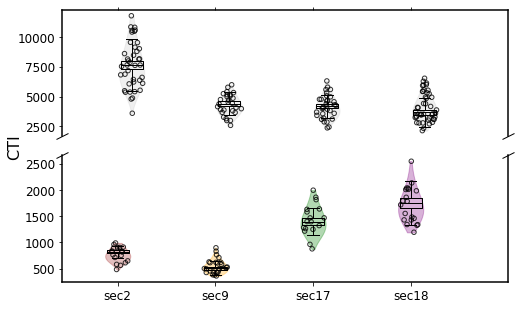

In [64]:
home     = "/home/jsortiz/phd/Paper_Tethering/Copy_Number_LiveCell/"
maxI_ref = []
maxI_tar = []
for ids in ["sec2","sec9","sec17","sec18"]: # Loop over replicates
    
    data  = pd.read_csv(home+"240319_copyNumber/_boxplot/%s.csv"%ids)        
    data["Set_ID"] = ids
    maxI_tar.append(data)    
    
    data  = pd.read_csv(home+"240319_copyNumber/_boxplot/%s_ref.csv"%ids)
    data["Set_ID"] = ids
    maxI_ref.append(data)    
    
maxI_ref = pd.concat(maxI_ref,ignore_index=True)
maxI_tar = pd.concat(maxI_tar,ignore_index=True)
maxI_tar["CTI"] = maxI_tar["I_BG"]*9
maxI_ref["CTI"] = maxI_ref["I_BG"]*37
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#print("%10s \tDistal %16s %15s %12s"%("Set","N","Proximal","N"))
colors = {"Sec9_AA":"c","sec2":"brown","WT":[0.4,0.4,1],"sec9":"orange","sec18":"purple","sec17":'g',
          "Other":"y","Control":"lightblue"}

sets = maxI_tar["Set_ID"].unique()
n_cse4   = 76.8
err_cse4 = 9.8

fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True,figsize=(len(sets)*2,5))
fig.subplots_adjust(hspace=0.15)  # adjust space between Axes

print("%8s %6s %3s %20s"%("Subunit","","Ntracks","Median +- SEM CTI (a.u.)"))

for i,ids in enumerate(sets):    

    target  = maxI_tar.query("Set_ID=='%s' and Frames>=3"%ids)["CTI"].copy() 
    refer   = maxI_ref.query("Set_ID=='%s'"%ids)["CTI"].copy() 
    n,n_err,sig_tar,sig_ref = errn(target,refer,n_cse4,err_cse4)    

    for j in [0,1]:
        
        ax   = ax2 if j == 0 else ax1        
        idp  = ids if ids in ["sec2","sec9","sec17","sec18"] else "WT"
        
        x    = target if j == 0 else refer
        mean = x.median()                
        nt   = len(x)
        sem  = sig_tar if j == 0 else sig_ref
        sd   = sem*np.sqrt(nt)    
        
        print("%8s %6s %3d %8.1f +- %3.1f"%(ids,"target" if j == 0 else "refer",len(x),mean,sem))        
        
        denplot(x,xshift=3.5*i+ 0.5*j,ax=ax,style=2,color=colors[idp] if j == 0 else '.8',alpha=0.3)
        
        
        ax.bxp([dict({
                "med"    : mean,
                "q1"     : mean-sem,
                "q3"     : mean+sem,
                "whislo" : mean-sd,
                "whishi" : mean+sd})],
               positions=[(3.5*i+ 0.5*j)],showfliers=False,patch_artist=False,               
               medianprops={"color":'.0','lw':1},
               widths=.8,zorder=50+j)
        ax.set_ylabel(None)
    
    print("%10s %3.1f +- %3.1f"% ("Copy number",n, n_err))
    print("++"*30)

ax1.set_xlim(-2,3.5*len(sets))

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

### Now, let's turn towards the cut-out slanted lines.
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)

ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

fig.text(0.03, 0.5, 'CTI', va='center', rotation='vertical',fontsize=16)
ax1.set_xticks(np.arange(len(sets))*3.5)
ax1.set_xticklabels(sets)
plt.show()